In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

d:\mlp\machinelearning\venv\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\mlp\MachineLearning\venv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


#### Генератор и дискриминатор будем делать исходя из статьи
<br>

![Схема генератора из статьи](./images/generator_scheme.png)

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(
                in_channels=channels,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2,2),
                padding=1
            ),
            nn.LeakyReLU(0.2),
            self._conv_block(128, 256, 4, 2, 1),
            self._conv_block(256, 512, 4, 2, 1),
            self._conv_block(512, 1024, 4, 2, 1),
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=(4,4), stride=(1,1), padding=0),
            nn.Sigmoid()
        )
    def _conv_block(self, in_channels, out_channels, kernel, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels = in_channels,
                out_channels=out_channels,
                kernel_size=kernel,
                stride=stride,
                padding=padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.discriminator(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, channels, z_dim):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            self._unconv_block(in_channels=z_dim, out_channels=1024, kernel=(4,4), stride=(1,1), padding=0),
            self._unconv_block(in_channels=1024, out_channels=512, kernel=(4,4), stride=(2,2), padding=1),
            self._unconv_block(in_channels=512, out_channels=256, kernel=(4,4), stride=(2,2), padding=1),
            self._unconv_block(in_channels=256, out_channels=128, kernel=(4,4), stride=(2,2), padding=1),
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=channels,
                               kernel_size=(4,4),
                               stride=(2,2),
                               padding=(1,1)),
            nn.Tanh()
        )
    def _unconv_block(self, in_channels, out_channels, kernel, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel,
                               stride=stride,
                               padding=padding,
                               bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self, x):
        return self.generator(x)

In [4]:
### Инициализация начального распределения параметров модели
def init_weights(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(module.weight.data, 0, 0.02)

In [5]:
### Обучение

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 2e-4
batch_size = 128
img_size = 64
channels = 1
z_dim = 100
num_epochs = 5

In [7]:
transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(tuple((0.5 for i in range(channels))), tuple((0.5 for i in range(channels))))
    ]
)

In [8]:
dataset = datasets.MNIST(root='MNIST_img/', transform=transforms, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
discriminator = Discriminator(channels=channels).to(device)
generator = Generator(channels=channels, z_dim=z_dim).to(device)
init_weights(generator)
init_weights(discriminator)

In [10]:
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas=(0.5, 0.999))
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [11]:
sample_batch = next(iter(dataloader))
sample_batch[0].shape, sample_batch[1].shape

(torch.Size([128, 1, 64, 64]), torch.Size([128]))

In [12]:
discriminator.forward(sample_batch[0].to(device)).view(batch_size).shape

torch.Size([128])

epoch 3, batch 305 of 469


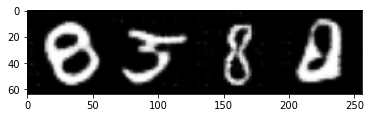

In [ ]:
default_noise = torch.randn(batch_size, z_dim,1,1).to(device)
bceloss = nn.BCELoss()
for epoch in tqdm(range(num_epochs)):
    loss_gen = 0
    loss_disc = 0
    loss_gen = 0
    for batch_idx, (image, _) in enumerate(dataloader):
        image = image.to(device)
        d_real = discriminator(image).squeeze(-1)

        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = generator.forward(noise)
        d_fake = discriminator.forward(fake).view(batch_size)

        # calculate loss function
        #discriminator
        loss_d = bceloss(d_real, torch.ones_like(d_real)) + bceloss(d_fake, torch.zeros_like(d_fake))
        loss_disc+=loss_d.detach().item()
        discriminator.zero_grad()
        loss_d.backward(retain_graph=True)
        optimizer_d.step()

        #generator
        d_fake = discriminator.forward(fake).view(batch_size)
        loss_g = bceloss(d_fake, torch.ones_like(d_fake))
        generator.zero_grad()
        loss_g.backward()
        optimizer_g.step()
        loss_gen+=loss_g.detach().item()
        clear_output()
        # print(f'loss_gen={loss_gen/batch_size}, loss_disc={loss_disc/batch_size}')
        print(f'epoch {epoch}, batch {batch_idx} of {len(dataloader)}')
        images = (generator.forward(default_noise).reshape(batch_size, 1, img_size, img_size)*0.5+0.5).cpu().detach().numpy()
        plt.imshow(np.concatenate(images[:, 0, :, :], axis=1)[:, :img_size*4], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
        plt.show()

In [37]:
tuple((0.5 for i in range(channels)))

(0.5, 0.5, 0.5)

In [25]:
init_weights(a)

In [ ]:
nn.init.normal_()

In [14]:
list(a.modules())[0]

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(12

In [5]:
isinstance([1,2,3], (tuple, tuple))

False

In [10]:
a = Generator(3, 100)

In [62]:
test_batch = torch.ones((32, 100, 1,1))

In [63]:
test_batch.shape

torch.Size([32, 100, 1, 1])

In [64]:
a.forward(test_batch).shape

torch.Size([32, 3, 64, 64])